In [11]:
# %pip install pandas
# %pip install tensorflow==2.14
# %pip install trfl
# %pip install scikit-learn
# %pip install tensorflow_probability


In [12]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from MY.data_processing import sample_data, split_data, get_statistics, preprocess_books, shorten_sessions

In [13]:
n_sessions = 7000
# sorted_events = sample_data('data', 'events.csv')
sorted_events = pd.read_csv('data/sorted_events.csv')
ch_sorted_events = shorten_sessions(sorted_events, n_sessions=n_sessions)
train_df, val_df, test_df = split_data(ch_sorted_events)
replay_buf, data_stats = get_statistics(ch_sorted_events, train_df)

unique: 16805 min: 0 max: 16804


In [14]:
books_df, rated_books_df = preprocess_books('books_dataset/interactions.csv')
books_df = shorten_sessions(books_df, n_sessions=n_sessions)


         session_id  item_id  timestamp  is_buy
0            126706    14433          0       1
1            127290   140952          0       0
2             66991   198453          0       1
3             46791    83486          0       0
4             79313   188770          0       1
...             ...      ...        ...     ...
1533073       76968   285394        729       1
1533074      153877   285394        729       1
1533075       90021    73789        729       1
1533076        6452    77993        729       0
1533077       70445   230195        729       0

[1527287 rows x 4 columns]
unique: 34622 min: 0 max: 34621


In [15]:
books_train_df, books_val_df, books_test_df = split_data(books_df)
books_replay_buf, books_data_stats = get_statistics(books_df, books_train_df)

In [16]:
books_data_stats

,state_size,item_num
0,10,34622


In [17]:
data_stats

,state_size,item_num
0,10,16805


In [18]:
from MY.RL_RECSYS import QNetwork, evaluate

def train(data_stats, replay_buf, val_df, arg_dict, results, losses, configuration='DQN', pickle=False, data_dir='data'):
    # Network parameters
    data_directory = data_dir
    if pickle:
        data_statis = pd.read_pickle(
            os.path.join(data_directory, 'data_statis.df'))  # read data statistics, includeing state_size and item_num
    else:
        data_statis = data_stats
    
    state_size = data_statis['state_size'][0]  # the length of history to define the state
    item_num = data_statis['item_num'][0]  # total number of items
    reward_click = arg_dict['r_click']
    reward_buy = arg_dict['r_buy']
    reward_negative=arg_dict['r_negative']
    topk=[5,10,15,20]
    # save_file = 'pretrain-GRU/%d' % (hidden_size)

    tf.compat.v1.reset_default_graph()

    QN_1 = QNetwork(name='QN_1', state_size=state_size, item_num=item_num, arg_dict=arg_dict, configuration=configuration, sequential_model='SASRec')
    QN_2 = QNetwork(name='QN_2', state_size=state_size, item_num=item_num, arg_dict=arg_dict, configuration=configuration, sequential_model='SASRec')
    if pickle:
        replay_buffer = pd.read_pickle(os.path.join(data_directory, 'replay_buffer.df'))
    else:
        replay_buffer = replay_buf
    # saver = tf.train.Saver()
    
    pop_dict=None
    if configuration=='SA2C':
        with open(os.path.join(data_directory, 'pop_dict.txt'), 'r') as f:
            pop_dict = eval(f.read())

    total_step=0
    with tf.compat.v1.Session() as sess:
        # Initialize variables
        sess.run(tf.compat.v1.global_variables_initializer())
        evaluate(sess, QN_1, val_df, state_size, item_num, reward_click, reward_buy, results, pop_dict=pop_dict, pickle=pickle)
        num_rows=replay_buffer.shape[0]
        num_batches=int(num_rows/arg_dict['batch_size'])
        for i in range(arg_dict['epoch']):
            for j in range(num_batches):
                batch = replay_buffer.sample(n=arg_dict['batch_size']).to_dict()

                #state = list(batch['state'].values())

                next_state = list(batch['next_state'].values())
                len_next_state = list(batch['len_next_states'].values())
                # double q learning, pointer is for selecting which network  is target and which is main
                pointer = np.random.randint(0, 2)
                if pointer == 0:
                    mainQN = QN_1
                    target_QN = QN_2
                else:
                    mainQN = QN_2
                    target_QN = QN_1
                target_Qs = sess.run(target_QN.output1,
                                     feed_dict={target_QN.inputs: next_state,
                                                target_QN.len_state: len_next_state,
                                                target_QN.is_training:True})
                target_Qs_selector = sess.run(mainQN.output1,
                                              feed_dict={mainQN.inputs: next_state,
                                                         mainQN.len_state: len_next_state,
                                                         mainQN.is_training:True})
                # Set target_Qs to 0 for states where episode ends
                is_done = list(batch['is_done'].values())
                for index in range(target_Qs.shape[0]):
                    if is_done[index]:
                        target_Qs[index] = np.zeros([item_num])

                state = list(batch['state'].values())
                len_state = list(batch['len_state'].values())
                target_Q_current = sess.run(target_QN.output1,
                                            feed_dict={target_QN.inputs: state,
                                                       target_QN.len_state: len_state,
                                                       target_QN.is_training:True})
                target_Q__current_selector = sess.run(mainQN.output1,
                                                      feed_dict={mainQN.inputs: state,
                                                                 mainQN.len_state: len_state,
                                                                 mainQN.is_training:True})
                action = list(batch['action'].values())
                negative=[]

                for index in range(target_Qs.shape[0]):
                    negative_list=[]
                    for i in range(arg_dict['neg']):
                        neg=np.random.randint(item_num)
                        while neg==action[index]:
                            neg = np.random.randint(item_num)
                        negative_list.append(neg)
                    negative.append(negative_list)

                is_buy=list(batch['is_buy'].values())
                reward=[]
                for k in range(len(is_buy)):
                    reward.append(reward_buy if is_buy[k] == 1 else reward_click)
                discount = [arg_dict['discount']] * len(action)
                
                if configuration == 'DQN' or configuration == 'SNQN':
                    loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                    feed_dict={mainQN.inputs: state,
                                                mainQN.len_state: len_state,
                                                mainQN.targetQs_: target_Qs,
                                                mainQN.reward: reward,
                                                mainQN.discount: discount,
                                                mainQN.actions: action,
                                                mainQN.targetQs_selector: target_Qs_selector,
                                                mainQN.negative_actions:negative,
                                                mainQN.targetQ_current_:target_Q_current,
                                                mainQN.targetQ_current_selector:target_Q__current_selector,
                                                mainQN.is_training:True
                                                })
                elif configuration == 'SA2C':
                    if total_step < 15000:
                        loss, _ = sess.run([mainQN.loss1, mainQN.opt1],
                                        feed_dict={mainQN.inputs: state,
                                                    mainQN.len_state: len_state,
                                                    mainQN.targetQs_: target_Qs,
                                                    mainQN.reward: reward,
                                                    mainQN.discount: discount,
                                                    mainQN.actions: action,
                                                    mainQN.targetQs_selector: target_Qs_selector,
                                                    mainQN.negative_actions: negative,
                                                    mainQN.targetQ_current_: target_Q_current,
                                                    mainQN.targetQ_current_selector: target_Q__current_selector,
                                                    mainQN.is_training:True
                                                    })
                    else:
                        behavior_prob = []
                        for a in action:
                            behavior_prob.append(pop_dict[a])

                        loss, _ = sess.run([mainQN.loss2, mainQN.opt2],
                                        feed_dict={mainQN.inputs: state,
                                                    mainQN.len_state: len_state,
                                                    mainQN.targetQs_: target_Qs,
                                                    mainQN.reward: reward,
                                                    mainQN.discount: discount,
                                                    mainQN.actions: action,
                                                    mainQN.targetQs_selector: target_Qs_selector,
                                                    mainQN.negative_actions: negative,
                                                    mainQN.targetQ_current_: target_Q_current,
                                                    mainQN.targetQ_current_selector: target_Q__current_selector,
                                                    mainQN.behavior_prob: behavior_prob,
                                                    mainQN.is_training:True
                                                    })
                total_step += 1
                if total_step % 50 == 0:
                    print("the loss in %dth batch is: %f" % (total_step, loss))
                    losses.append(loss)
                if total_step % 250 == 0:
                    evaluate(sess, QN_1, val_df, state_size, item_num, reward_click, reward_buy, results, pop_dict=pop_dict, pickle=pickle)
    return QN_1, QN_2

In [19]:
def last_results(results, print_out=False):
       res = ''
       res += ('Rewards:\n @5 : ' + str(results[-1][5]['reward']) +
             ' @10 : ' + str(results[-1][10]['reward']) +
             ' @15 : ' + str(results[-1][15]['reward']) + ' @20 : ' + str(results[-1][20]['reward']))
       res += '\n\n'
       res += ('Click HR:\n @5 : ' + str(results[-1][5]['click hr']) +
             ' @10 : ' + str(results[-1][10]['click hr']) +
             ' @15 : ' + str(results[-1][15]['click hr']) + ' @20 : ' + str(results[-1][20]['click hr']))
       res += '\n\n'
       res += ('Click NDCG:\n @5 : ' + str(results[-1][5]['click ndcg']) +
             ' @10 : ' + str(results[-1][10]['click ndcg']) +
             ' @15 : ' + str(results[-1][15]['click ndcg']) + ' @20 : ' + str(results[-1][20]['click ndcg']))
       res += '\n\n'
       res += ('Purchase HR:\n @5 : ' + str(results[-1][5]['purchase hr']) +
             ' @10 : ' + str(results[-1][10]['purchase hr']) +
             ' @15 : ' + str(results[-1][15]['purchase hr']) + ' @20 : ' + str(results[-1][20]['purchase hr']))
       res += '\n\n'
       res += ('Purchase NDCG:\n @5 : ' + str(results[-1][5]['purchase ndcg']) +
             ' @10 : ' + str(results[-1][10]['purchase ndcg']) +
             ' @15 : ' + str(results[-1][15]['purchase ndcg']) + ' @20 : ' + str(results[-1][20]['purchase ndcg']))
       if print_out:
            print(res)
            
       return res
      
      # print('Click HR:\n @5 :', results[-1][5]['click hr'],
      #       '@10 :', results[-1][10]['click hr'], '@15 :', results[-1][15]['click hr'],
      #       '@20 :', results[-1][20]['click hr'])
      # print('Click NDCG:\n @5 :', results[-1][5]['click ndcg'],
      #       '@10 :', results[-1][10]['click ndcg'], '@15 :', results[-1][15]['click ndcg'],
      #       '@20 :', results[-1][20]['click ndcg'])
      # print('Purchase HR:\n @5 :', results[-1][5]['purchase hr'],
      #       '@10 :', results[-1][10]['purchase hr'], '@15 :', results[-1][15]['purchase hr'],
      #       '@20 :', results[-1][20]['purchase hr'])
      # print('Purchase NDCG:\n @5 :', results[-1][5]['purchase ndcg'],
      #       '@10 :', results[-1][10]['purchase ndcg'], '@15 :', results[-1][15]['purchase ndcg'],
      #       '@20 :', results[-1][20]['purchase ndcg'])

# DQN

In [20]:
arg_dict = {'r_click' : 0.2,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.001,
            'epoch' : 50,
            'batch_size' : 256,
            'neg' : 10,
            'discount' : 0.5
            }
results = []
losses = []
QN_1, QN_2 = train(data_stats, replay_buf, val_df, arg_dict=arg_dict, results=results, losses=losses)

/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/RL_RECSYS.py:95: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:142: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:143: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:144: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.la

#############################################################
total clicks: 4154, total purchase:171
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 5: 0.200000
clicks hr ndcg @ 5 : 0.000241, 0.000104
purchase hr and ndcg @5 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 10: 0.200000
clicks hr ndcg @ 10 : 0.000241, 0.000104
purchase hr and ndcg @10 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 15: 0.600000
clicks hr ndcg @ 15 : 0.000722, 0.000231
purchase hr and ndcg @15 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 20: 0.800000
clicks hr ndcg @ 20 : 0.000963, 0.000289
purchase hr and ndcg @20 : 0.000000, 0.000000
#############################################################
the loss in 50th batch is: 3.018051
the loss in 100th batch is: 1.525057
the loss in 150th batch is: 2.574587
th

In [21]:
# %pip install matplotlib

In [22]:
import matplotlib.pyplot as plt

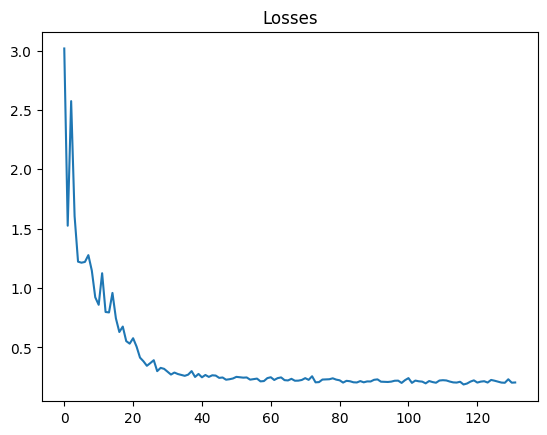

In [23]:
plt.plot(losses)
plt.title('Losses')
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


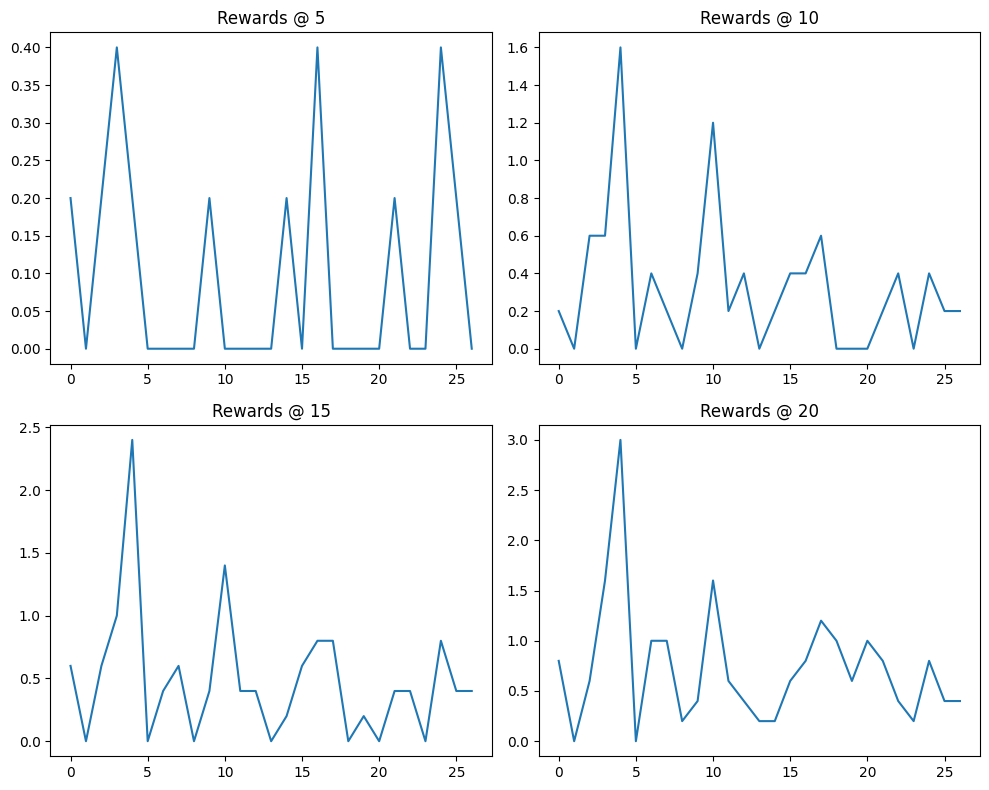

In [24]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['reward'] for el in results]
y_at10 = [el[10]['reward'] for el in results]
y_at15 = [el[15]['reward'] for el in results]
y_at20 = [el[20]['reward'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('Rewards @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('Rewards @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('Rewards @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('Rewards @ 20')

plt.tight_layout()

plt.show()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


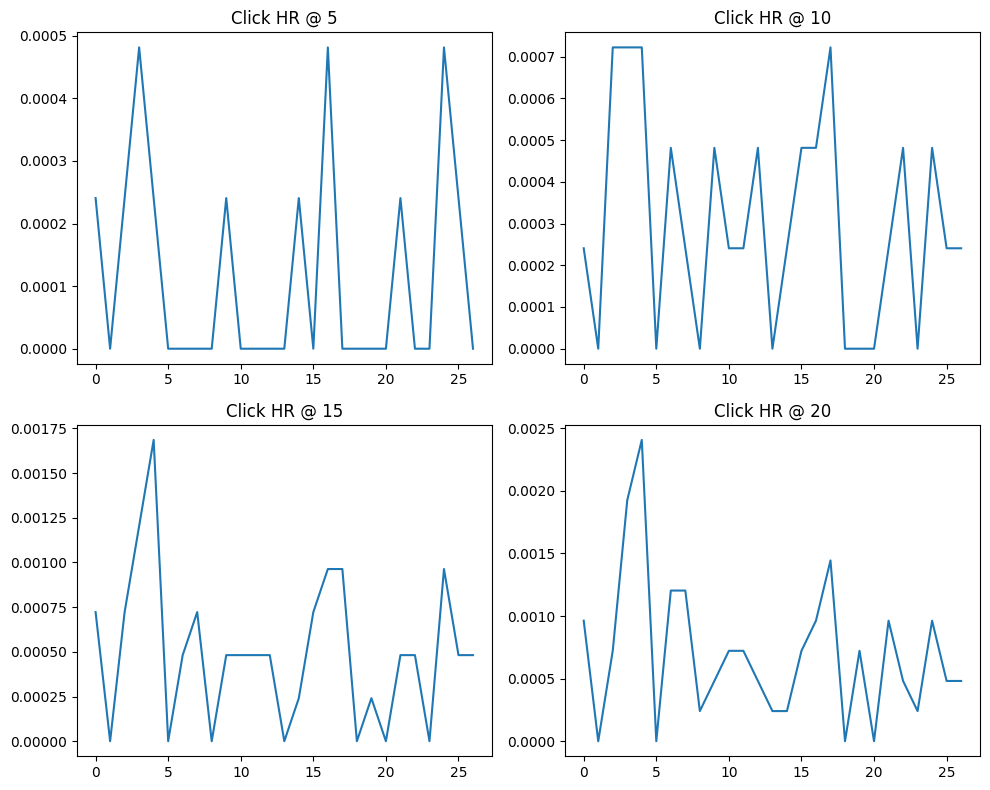

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['click hr'] for el in results]
y_at10 = [el[10]['click hr'] for el in results]
y_at15 = [el[15]['click hr'] for el in results]
y_at20 = [el[20]['click hr'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('Click HR @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('Click HR @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('Click HR @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('Click HR @ 20')

plt.tight_layout()

plt.show()

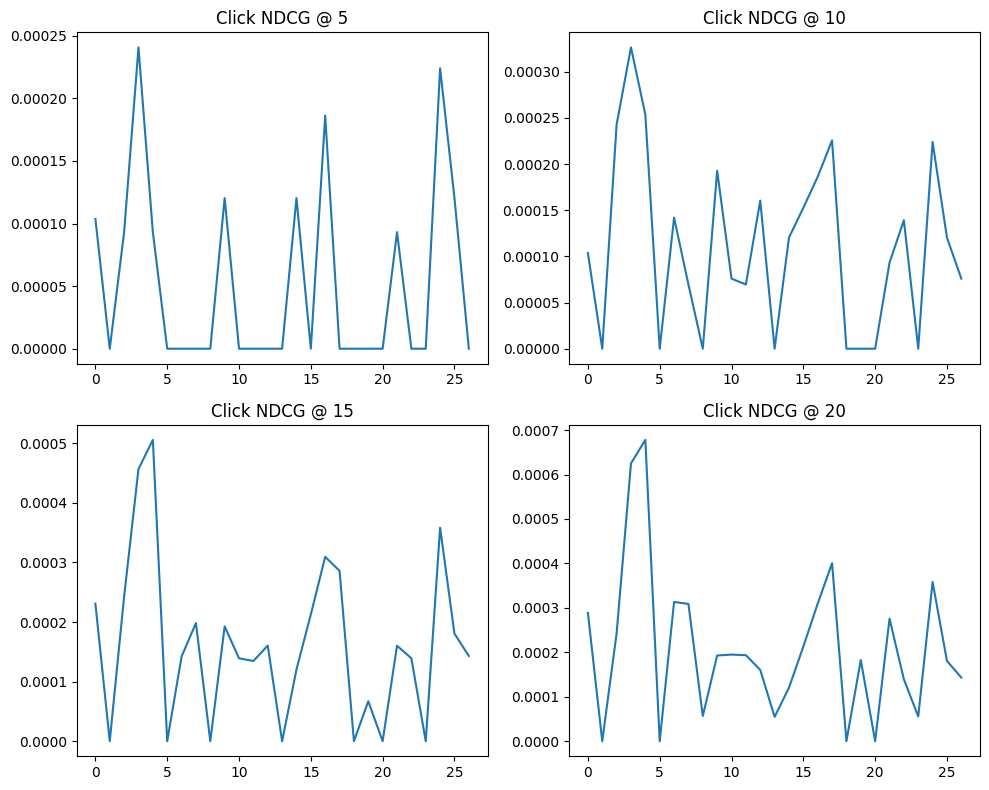

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# x = [i for i in range(len(results))]
# print(x)
y_at5 = [el[5]['click ndcg'] for el in results]
y_at10 = [el[10]['click ndcg'] for el in results]
y_at15 = [el[15]['click ndcg'] for el in results]
y_at20 = [el[20]['click ndcg'] for el in results]


axes[0, 0].plot(y_at5)
axes[0, 0].set_title('Click NDCG @ 5')

axes[0, 1].plot(y_at10)
axes[0, 1].set_title('Click NDCG @ 10')

axes[1, 0].plot(y_at15)
axes[1, 0].set_title('Click NDCG @ 15')

axes[1, 1].plot(y_at20)
axes[1, 1].set_title('Click NDCG @ 20')

plt.tight_layout()

plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


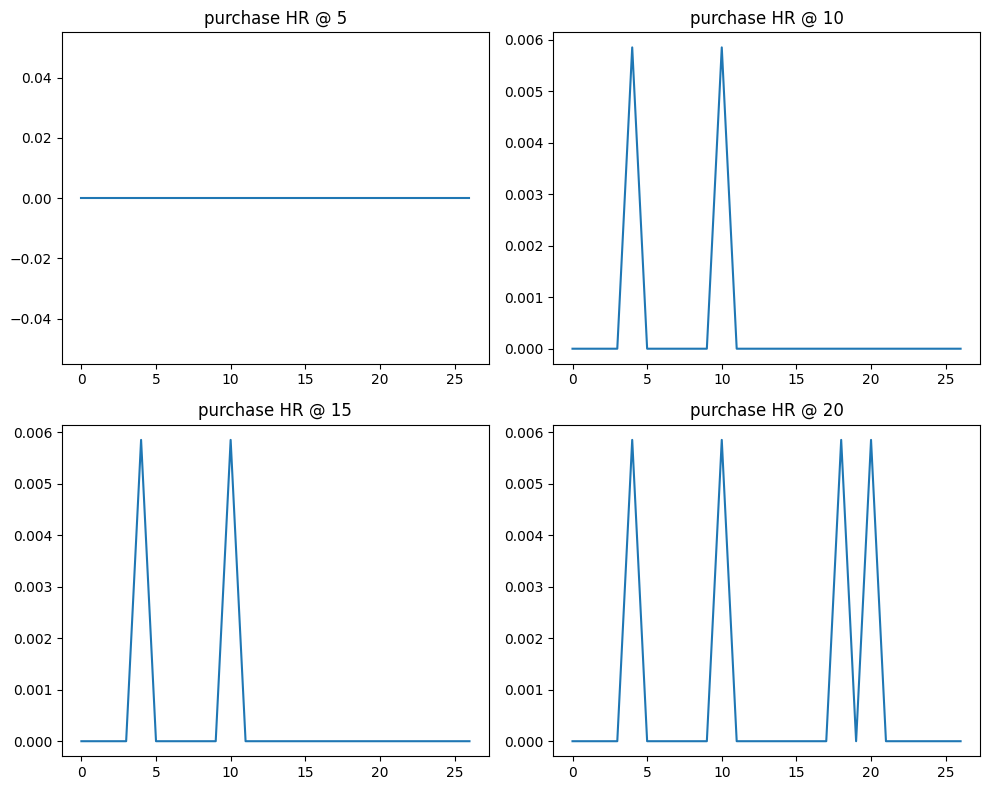

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['purchase hr'] for el in results]
y_at10 = [el[10]['purchase hr'] for el in results]
y_at15 = [el[15]['purchase hr'] for el in results]
y_at20 = [el[20]['purchase hr'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('purchase HR @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('purchase HR @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('purchase HR @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('purchase HR @ 20')

plt.tight_layout()

plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


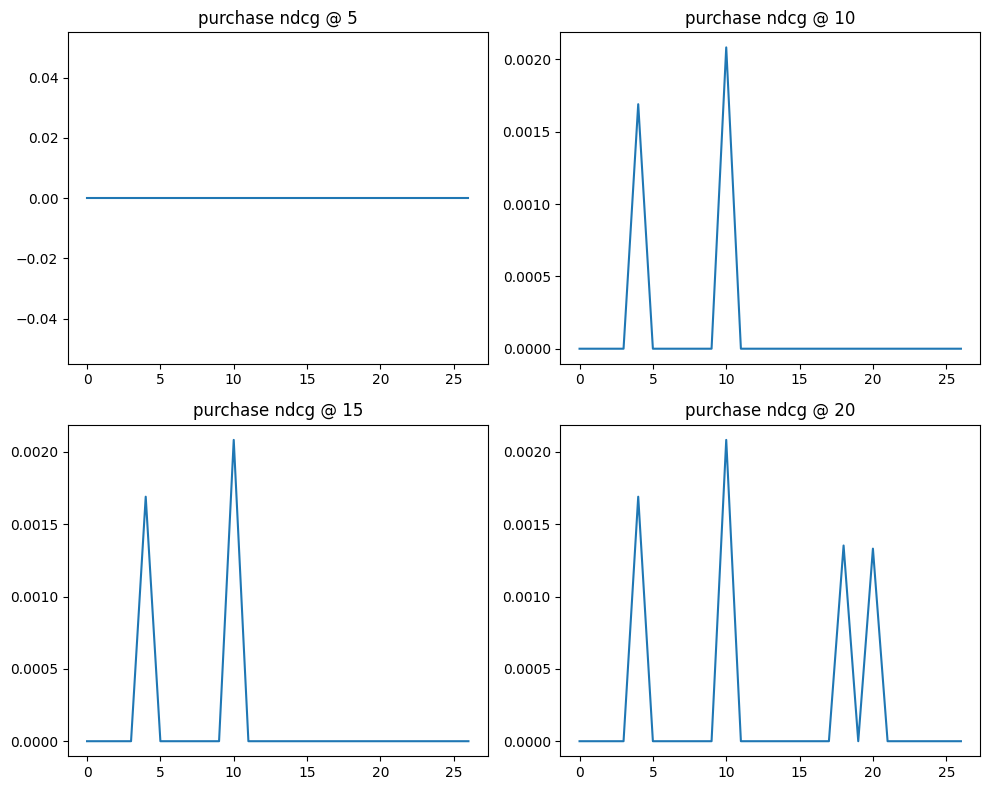

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['purchase ndcg'] for el in results]
y_at10 = [el[10]['purchase ndcg'] for el in results]
y_at15 = [el[15]['purchase ndcg'] for el in results]
y_at20 = [el[20]['purchase ndcg'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('purchase ndcg @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('purchase ndcg @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('purchase ndcg @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('purchase ndcg @ 20')

plt.tight_layout()

plt.show()

In [29]:
VAL_RESULTS_DQN = last_results(results)

# SNQN

/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/RL_RECSYS.py:95: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:142: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:143: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:144: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.la

#############################################################
total clicks: 4154, total purchase:171
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 5: 0.000000
clicks hr ndcg @ 5 : 0.000000, 0.000000
purchase hr and ndcg @5 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 10: 1.800000
clicks hr ndcg @ 10 : 0.000963, 0.000288
purchase hr and ndcg @10 : 0.005848, 0.001690
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 15: 2.000000
clicks hr ndcg @ 15 : 0.001204, 0.000351
purchase hr and ndcg @15 : 0.005848, 0.001690
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 20: 2.400000
clicks hr ndcg @ 20 : 0.001685, 0.000460
purchase hr and ndcg @20 : 0.005848, 0.001690
#############################################################
the loss in 50th batch is: 12.959801
the loss in 100th batch is: 11.851297
the loss in 150th batch is: 10.793318

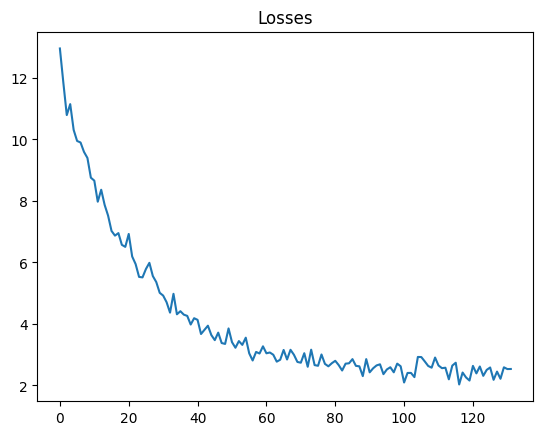

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


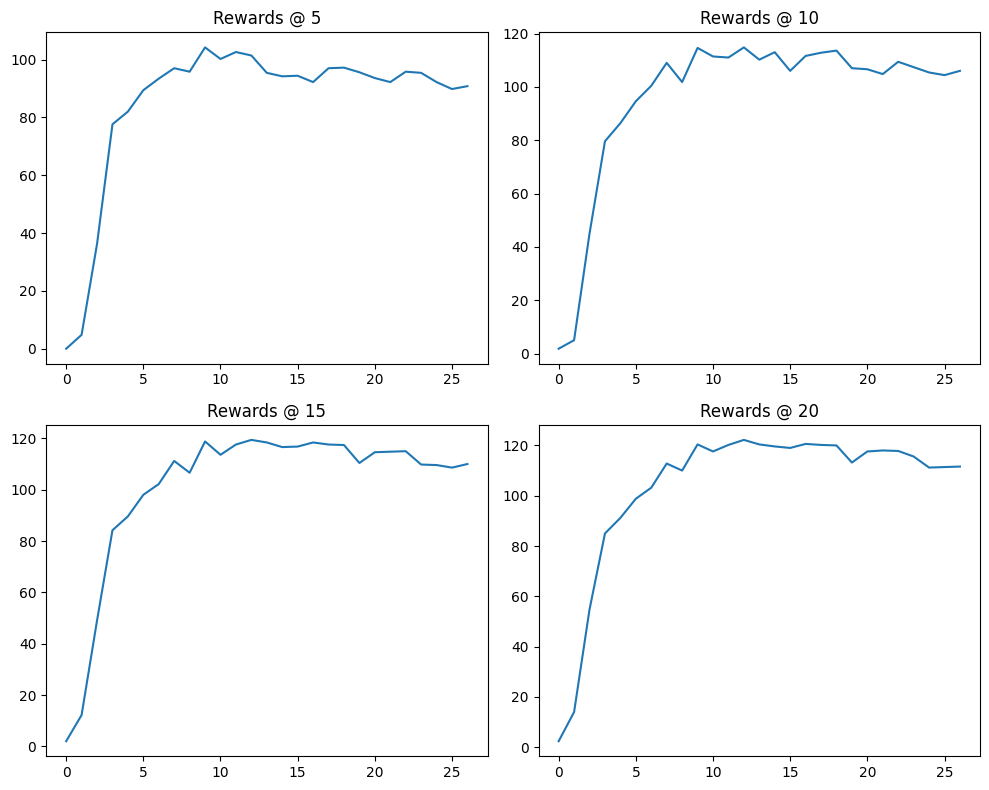

In [30]:

arg_dict = {'r_click' : 0.2,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.005,
            'epoch' : 50,
            'batch_size' : 256,
            'neg' : 10,
            'discount' : 0.5
            }
results = []
losses = []
QN_1, QN_2 = train(data_stats, replay_buf, val_df, arg_dict=arg_dict, results=results, losses=losses, configuration='SNQN')


plt.plot(losses)
plt.title('Losses')
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['reward'] for el in results]
y_at10 = [el[10]['reward'] for el in results]
y_at15 = [el[15]['reward'] for el in results]
y_at20 = [el[20]['reward'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('Rewards @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('Rewards @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('Rewards @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('Rewards @ 20')

plt.tight_layout()

plt.show()


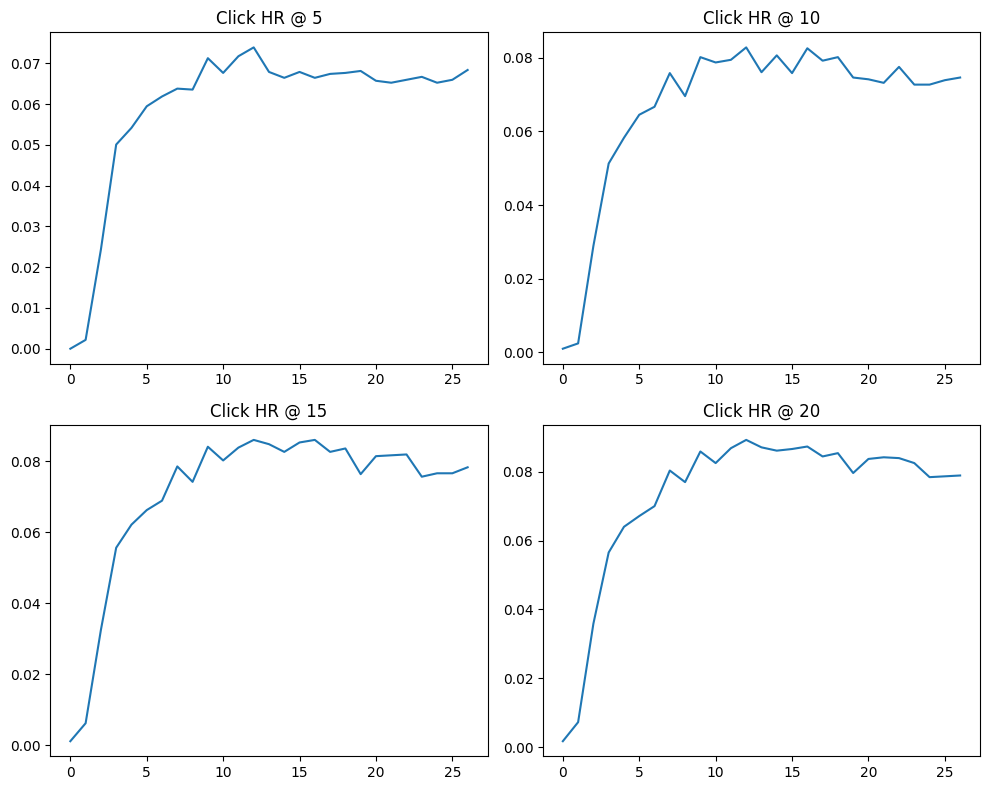

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
y_at5 = [el[5]['click hr'] for el in results]
y_at10 = [el[10]['click hr'] for el in results]
y_at15 = [el[15]['click hr'] for el in results]
y_at20 = [el[20]['click hr'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('Click HR @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('Click HR @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('Click HR @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('Click HR @ 20')

plt.tight_layout()

plt.show()

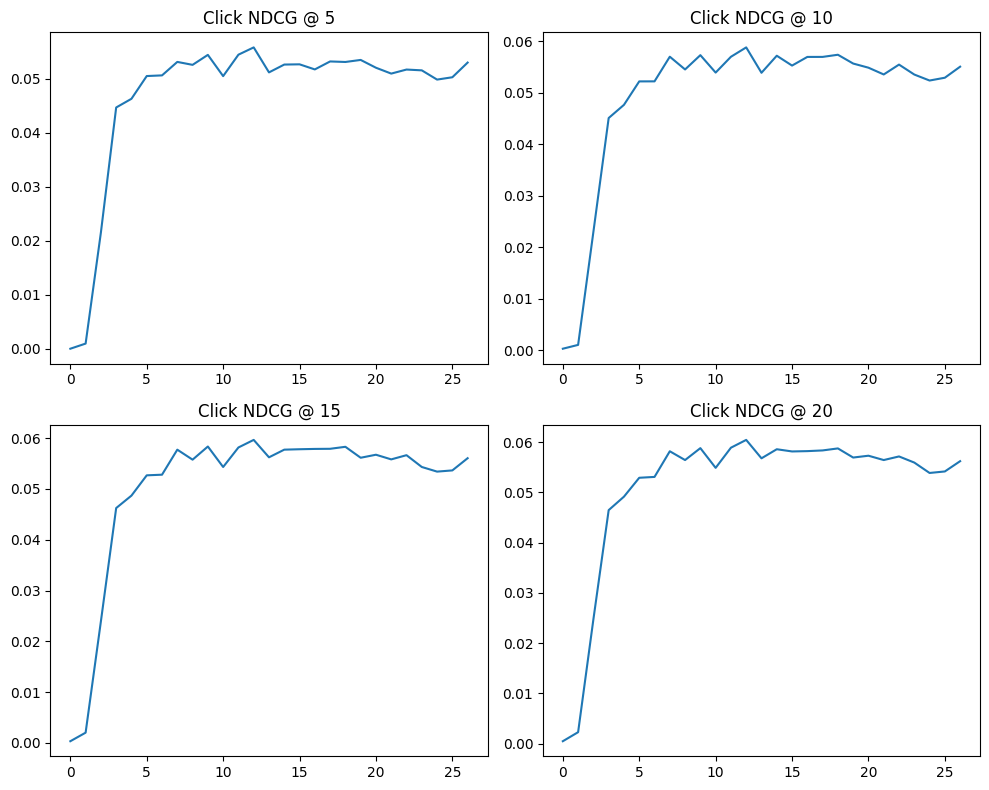

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# x = [i for i in range(len(results))]
# print(x)
y_at5 = [el[5]['click ndcg'] for el in results]
y_at10 = [el[10]['click ndcg'] for el in results]
y_at15 = [el[15]['click ndcg'] for el in results]
y_at20 = [el[20]['click ndcg'] for el in results]


axes[0, 0].plot(y_at5)
axes[0, 0].set_title('Click NDCG @ 5')

axes[0, 1].plot(y_at10)
axes[0, 1].set_title('Click NDCG @ 10')

axes[1, 0].plot(y_at15)
axes[1, 0].set_title('Click NDCG @ 15')

axes[1, 1].plot(y_at20)
axes[1, 1].set_title('Click NDCG @ 20')

plt.tight_layout()

plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


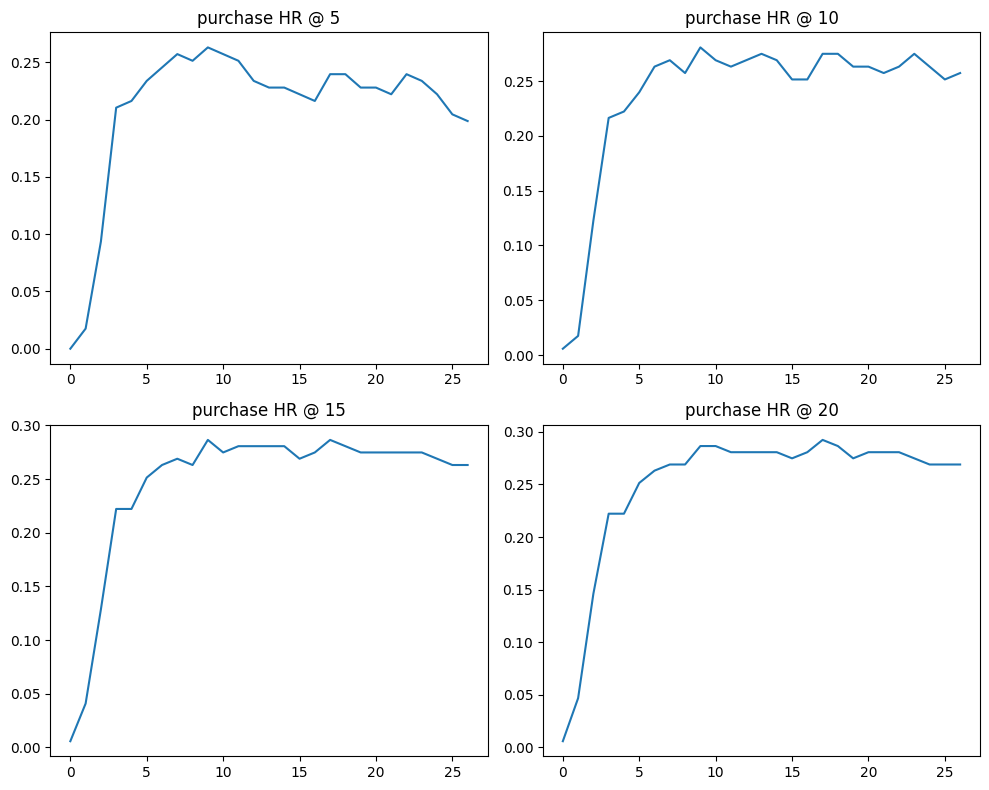

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['purchase hr'] for el in results]
y_at10 = [el[10]['purchase hr'] for el in results]
y_at15 = [el[15]['purchase hr'] for el in results]
y_at20 = [el[20]['purchase hr'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('purchase HR @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('purchase HR @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('purchase HR @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('purchase HR @ 20')

plt.tight_layout()

plt.show()



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


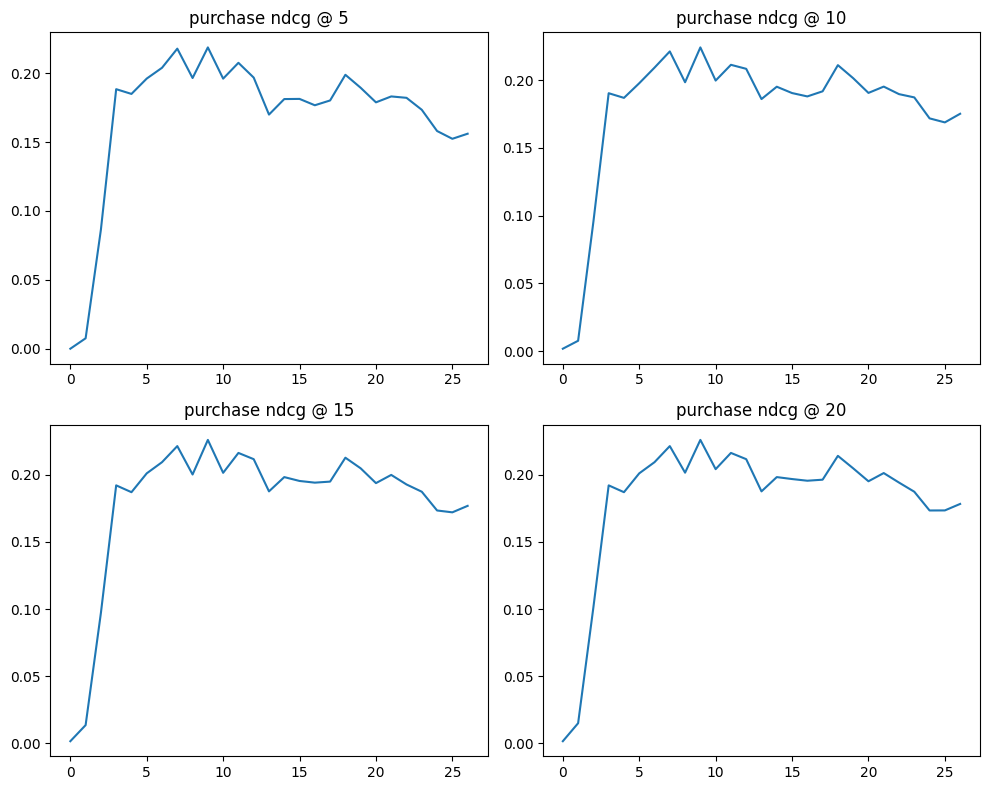

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['purchase ndcg'] for el in results]
y_at10 = [el[10]['purchase ndcg'] for el in results]
y_at15 = [el[15]['purchase ndcg'] for el in results]
y_at20 = [el[20]['purchase ndcg'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('purchase ndcg @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('purchase ndcg @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('purchase ndcg @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('purchase ndcg @ 20')

plt.tight_layout()

plt.show()

In [35]:
VAL_RESULTS_SNQN = last_results(results)

# SA2C

In [36]:
from MY.data_processing import create_pop_dict

create_pop_dict(data_dir='data')

9.0
20.0
1.0
27.0
21.0
18.0
15.0
16.0
26.0


/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/RL_RECSYS.py:95: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:142: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:143: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:144: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.la

#############################################################
total clicks: 4154, total purchase:171
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 5: 0.400000
clicks hr ndcg @ 5 : 0.000481, 0.000207
purchase hr and ndcg @5 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 10: 0.400000
clicks hr ndcg @ 10 : 0.000481, 0.000207
purchase hr and ndcg @10 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 15: 0.400000
clicks hr ndcg @ 15 : 0.000481, 0.000207
purchase hr and ndcg @15 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 20: 0.800000
clicks hr ndcg @ 20 : 0.000963, 0.000323
purchase hr and ndcg @20 : 0.000000, 0.000000
off-line corrected evaluation (click_ng,purchase_ng) @10: 0.000436, 0.000000
#############################################################
the loss in 50th batch is: 11.93224

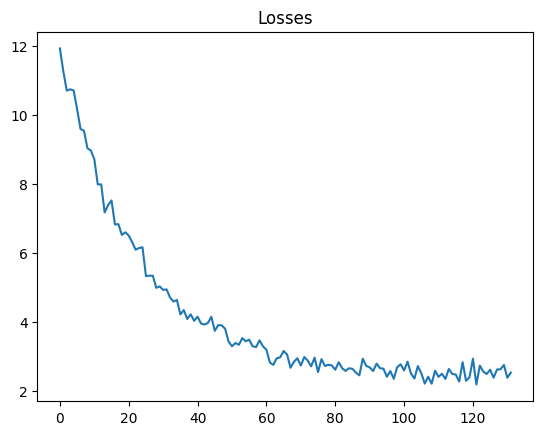

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


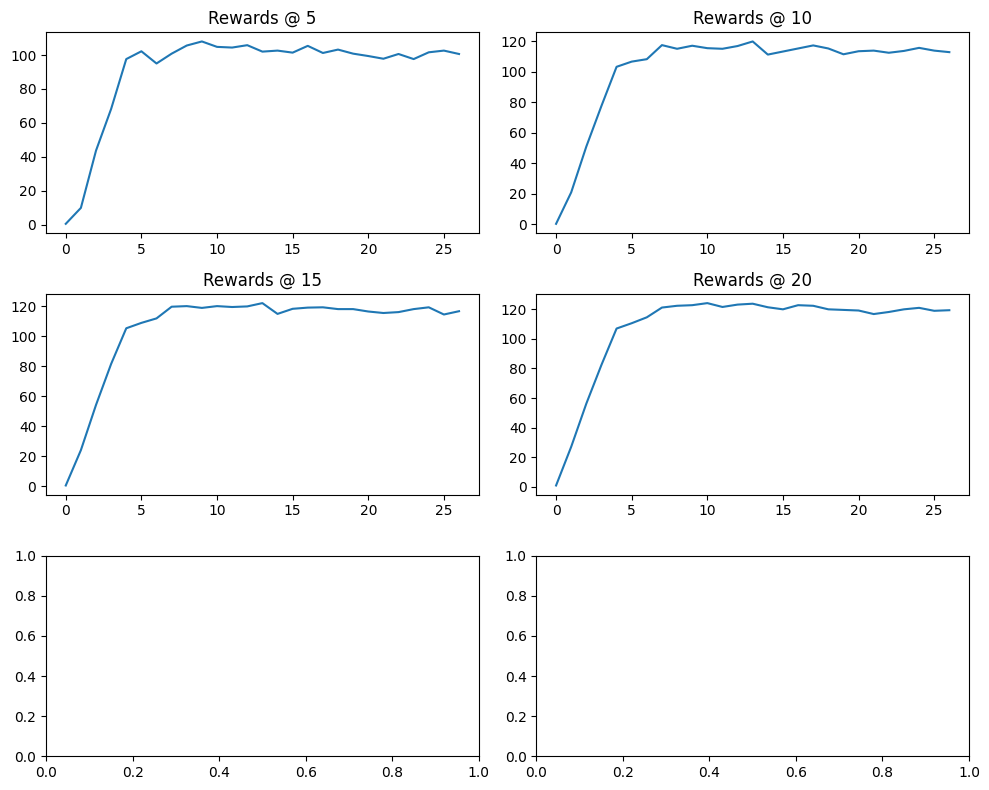

In [37]:
arg_dict = {'r_click' : 0.2,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.005,
            'lr2' : 0.001,
            'epoch' : 50,
            'batch_size' : 256,
            'neg' : 10,
            'discount' : 0.5,
            'smooth' : 0.0,
            'clip' : 0.0
            }
results = []
losses = []
QN_1, QN_2 = train(data_stats, replay_buf, val_df, arg_dict=arg_dict, results=results, losses=losses, configuration='SA2C')
plt.plot(losses)
plt.title('Losses')
plt.show()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['reward'] for el in results]
y_at10 = [el[10]['reward'] for el in results]
y_at15 = [el[15]['reward'] for el in results]
y_at20 = [el[20]['reward'] for el in results]


axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('Rewards @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('Rewards @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('Rewards @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('Rewards @ 20')

plt.tight_layout()

plt.show()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


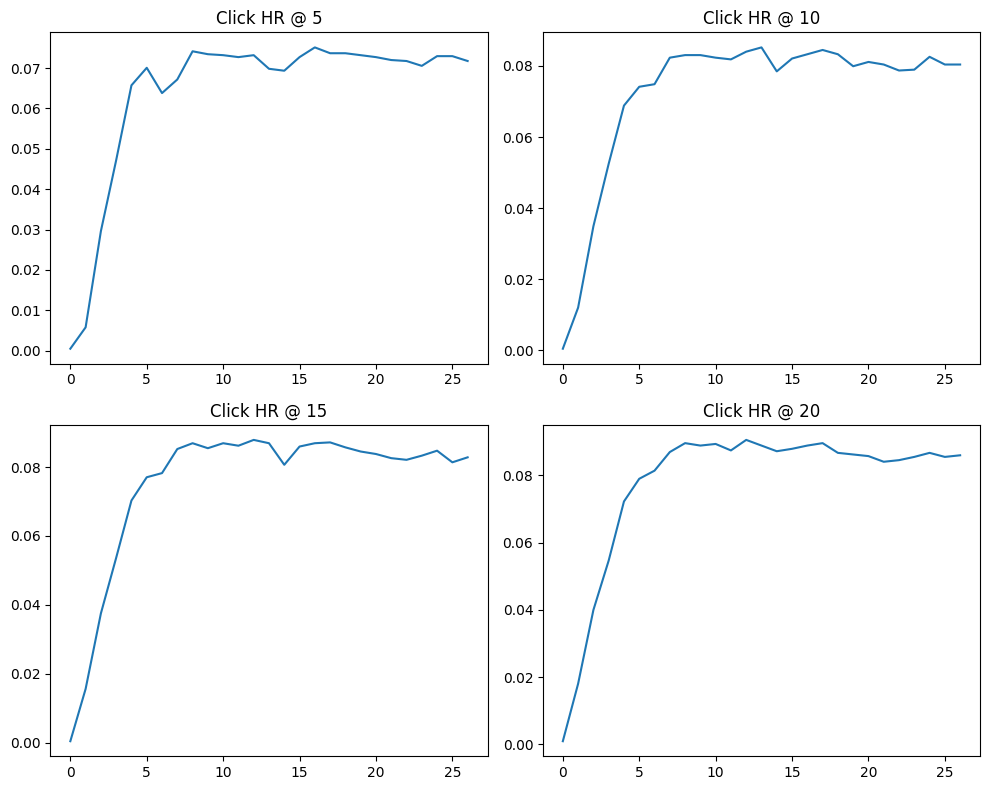

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['click hr'] for el in results]
y_at10 = [el[10]['click hr'] for el in results]
y_at15 = [el[15]['click hr'] for el in results]
y_at20 = [el[20]['click hr'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('Click HR @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('Click HR @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('Click HR @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('Click HR @ 20')

plt.tight_layout()

plt.show()



[0.00020735510740172992, 0.005133236836492, 0.02600717635274567, 0.04199090373320959, 0.05355450084323689, 0.05541393596002163, 0.0517044634061157, 0.05387466047156494, 0.05884745061804213, 0.05805508466347422, 0.0567214846399892, 0.05685781838743777, 0.051181682832681416, 0.05513191916993438, 0.052966581146448394, 0.055235746271711184, 0.057035959990298445, 0.0562615746801282, 0.05667032087533501, 0.05539406803928848, 0.05470296285796191, 0.05482178222407701, 0.054343138051992, 0.053897760707456936, 0.055819321736601195, 0.054595824047085635, 0.05461709170614374]


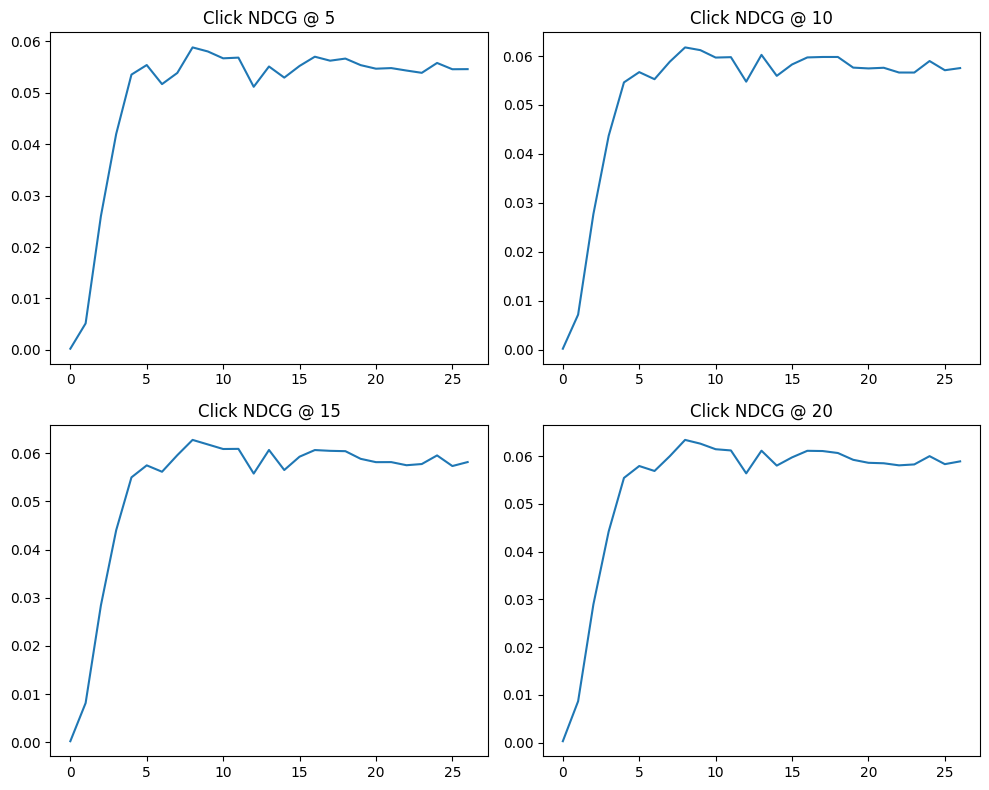

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# x = [i for i in range(len(results))]
# print(x)
y_at5 = [el[5]['click ndcg'] for el in results]
y_at10 = [el[10]['click ndcg'] for el in results]
y_at15 = [el[15]['click ndcg'] for el in results]
y_at20 = [el[20]['click ndcg'] for el in results]

print(y_at5)

axes[0, 0].plot(y_at5)
axes[0, 0].set_title('Click NDCG @ 5')

axes[0, 1].plot(y_at10)
axes[0, 1].set_title('Click NDCG @ 10')

axes[1, 0].plot(y_at15)
axes[1, 0].set_title('Click NDCG @ 15')

axes[1, 1].plot(y_at20)
axes[1, 1].set_title('Click NDCG @ 20')

plt.tight_layout()

plt.show()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


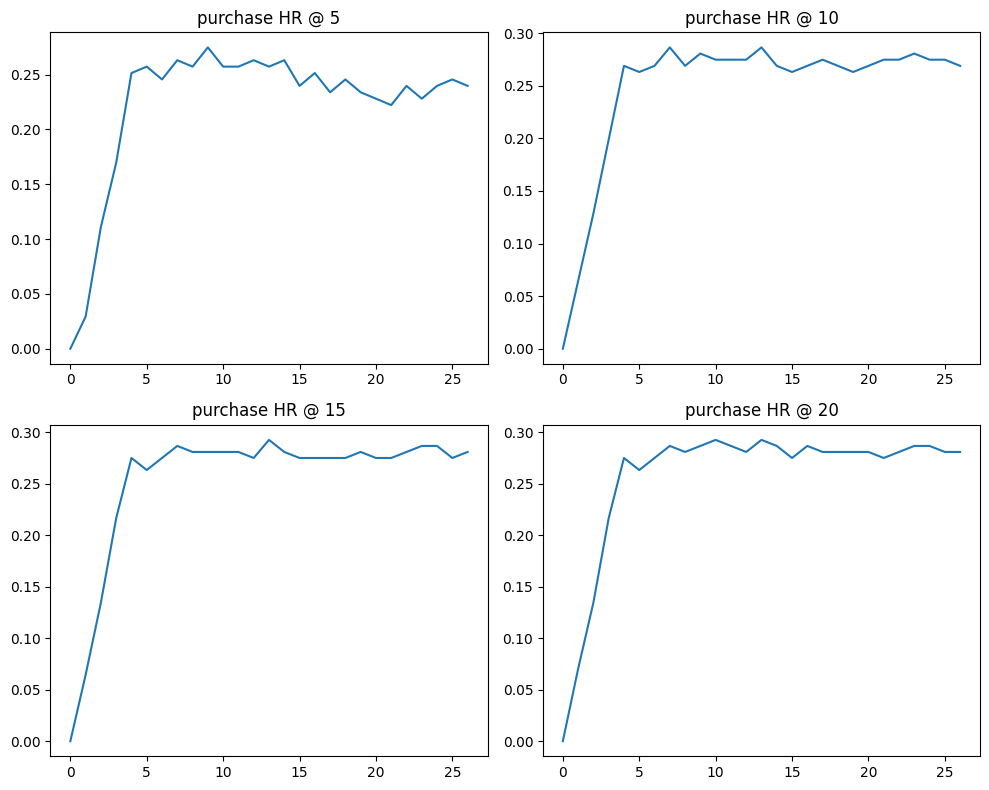

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['purchase hr'] for el in results]
y_at10 = [el[10]['purchase hr'] for el in results]
y_at15 = [el[15]['purchase hr'] for el in results]
y_at20 = [el[20]['purchase hr'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('purchase HR @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('purchase HR @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('purchase HR @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('purchase HR @ 20')

plt.tight_layout()

plt.show()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


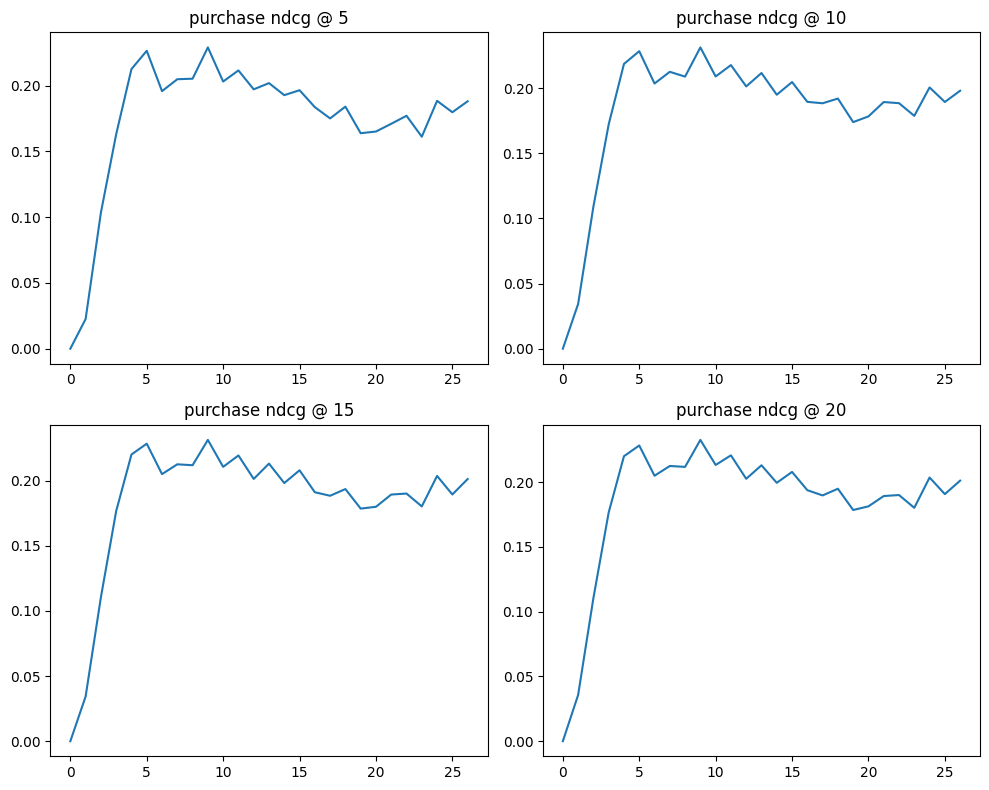

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x = [i for i in range(len(results))]
print(x)
y_at5 = [el[5]['purchase ndcg'] for el in results]
y_at10 = [el[10]['purchase ndcg'] for el in results]
y_at15 = [el[15]['purchase ndcg'] for el in results]
y_at20 = [el[20]['purchase ndcg'] for el in results]

axes[0, 0].plot(x, y_at5)
axes[0, 0].set_title('purchase ndcg @ 5')

axes[0, 1].plot(x, y_at10)
axes[0, 1].set_title('purchase ndcg @ 10')

axes[1, 0].plot(x, y_at15)
axes[1, 0].set_title('purchase ndcg @ 15')

axes[1, 1].plot(x, y_at20)
axes[1, 1].set_title('purchase ndcg @ 20')

plt.tight_layout()

plt.show()

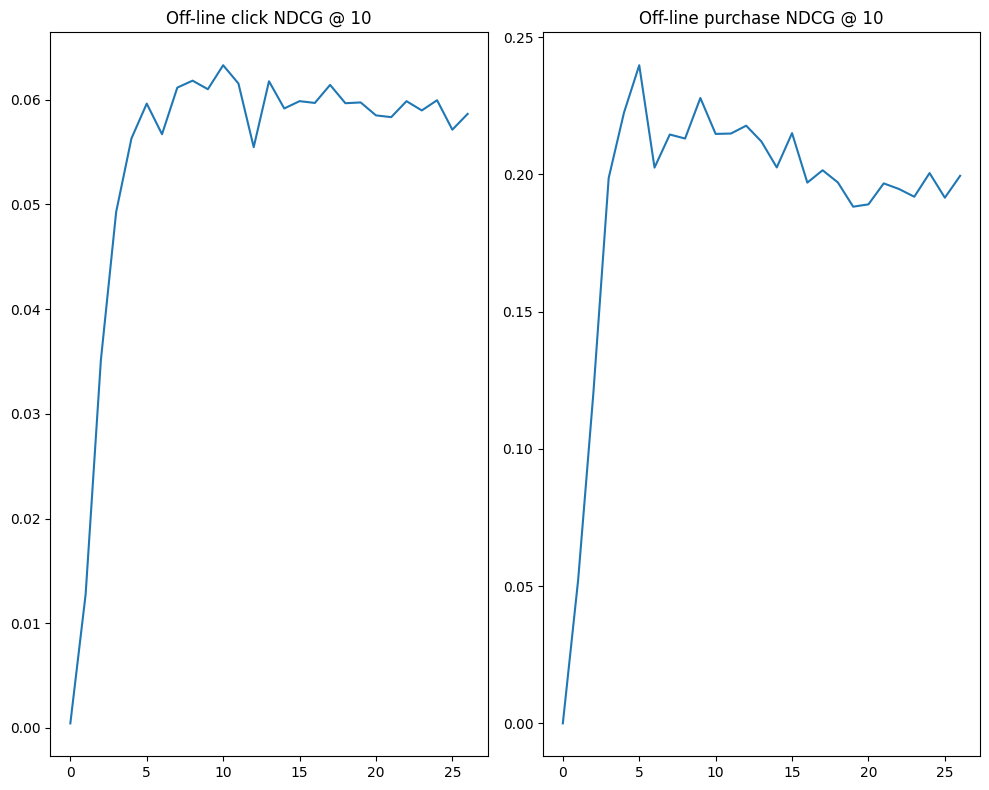

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
y_ofl_click = [el[10]['off-line click ndcg'] for el in results]
y_ofl_purchase = [el[10]['off-line purchase ndcg'] for el in results]

axes[0].plot(y_ofl_click)
axes[0].set_title('Off-line click NDCG @ 10')

axes[1].plot(y_ofl_purchase)
axes[1].set_title('Off-line purchase NDCG @ 10')

plt.tight_layout()
plt.show()

In [43]:
VAL_RESULTS_SA2C = last_results(results)

## Comparison

In [44]:
print('DQN: \n', VAL_RESULTS_DQN, '\n\n')
print('SNQN: \n', VAL_RESULTS_SNQN, '\n\n')
print('SA2C: \n', VAL_RESULTS_SA2C, '\n\n')

DQN: 
 Rewards:
 @5 : 0 @10 : 0.2 @15 : 0.4 @20 : 0.4

Click HR:
 @5 : 0.0 @10 : 0.00024073182474723158 @15 : 0.00048146364949446316 @20 : 0.00048146364949446316

Click NDCG:
 @5 : 0.0 @10 : 7.594243543228906e-05 @15 : 0.00014309287973925341 @20 : 0.00014309287973925341

Purchase HR:
 @5 : 0.0 @10 : 0.0 @15 : 0.0 @20 : 0.0

Purchase NDCG:
 @5 : 0.0 @10 : 0.0 @15 : 0.0 @20 : 0.0 


SNQN: 
 Rewards:
 @5 : 90.80000000000047 @10 : 106.00000000000057 @15 : 110.00000000000061 @20 : 111.6000000000006

Click HR:
 @5 : 0.06836783822821377 @10 : 0.07462686567164178 @15 : 0.07823784304285027 @20 : 0.07896003851709196

Click NDCG:
 @5 : 0.05300367321897576 @10 : 0.05506564690775588 @15 : 0.056030725800833764 @20 : 0.05619604084911342

Purchase HR:
 @5 : 0.19883040935672514 @10 : 0.2573099415204678 @15 : 0.2631578947368421 @20 : 0.26900584795321636

Purchase NDCG:
 @5 : 0.1560379927437867 @10 : 0.17525506841737876 @15 : 0.17683540850174903 @20 : 0.17826611342641704 


SA2C: 
 Rewards:
 @5 : 100.600

# Dataset with books

### DQN

In [45]:
arg_dict_books = {'r_click' : 0.2,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.001,
            'epoch' : 30,
            'batch_size' : 256,
            'neg' : 10,
            'discount' : 0.5
            }
results_books = []
losses_books = []
QN_1_books, QN_2_books = train(books_data_stats, books_replay_buf, books_val_df, arg_dict=arg_dict_books, results=results_books, losses=losses_books, configuration='DQN')

/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/RL_RECSYS.py:95: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:142: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:143: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:144: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.la

#############################################################
total clicks: 4499, total purchase:3011
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 5: 0.000000
clicks hr ndcg @ 5 : 0.000000, 0.000000
purchase hr and ndcg @5 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 10: 0.000000
clicks hr ndcg @ 10 : 0.000000, 0.000000
purchase hr and ndcg @10 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 15: 3.200000
clicks hr ndcg @ 15 : 0.000222, 0.000060
purchase hr and ndcg @15 : 0.000996, 0.000253
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 20: 3.200000
clicks hr ndcg @ 20 : 0.000222, 0.000060
purchase hr and ndcg @20 : 0.000996, 0.000253
#############################################################
the loss in 50th batch is: 3.828198
the loss in 100th batch is: 2.863694
the loss in 150th batch is: 2.239140
t

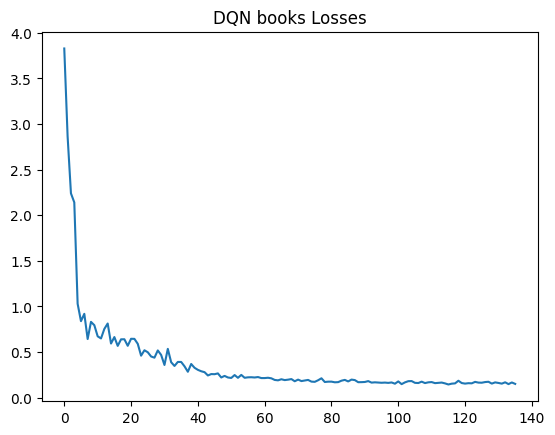

In [46]:
plt.plot(losses_books)
plt.title('DQN books Losses')
plt.show()

In [47]:
_ = last_results(results_books, print_out=True)

Rewards:
 @5 : 0.2 @10 : 0.2 @15 : 1.2 @20 : 1.2

Click HR:
 @5 : 0.0002222716159146477 @10 : 0.0002222716159146477 @15 : 0.0002222716159146477 @20 : 0.0002222716159146477

Click NDCG:
 @5 : 8.598639858513929e-05 @10 : 8.598639858513929e-05 @15 : 8.598639858513929e-05 @20 : 8.598639858513929e-05

Purchase HR:
 @5 : 0.0 @10 : 0.0 @15 : 0.00033211557622052476 @20 : 0.00033211557622052476

Purchase NDCG:
 @5 : 0.0 @10 : 0.0 @15 : 9.264129712757551e-05 @20 : 9.264129712757551e-05


### SNQN

/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/RL_RECSYS.py:95: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:142: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:143: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:144: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.la

#############################################################
total clicks: 4499, total purchase:3011
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 5: 0.200000
clicks hr ndcg @ 5 : 0.000222, 0.000096
purchase hr and ndcg @5 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 10: 0.200000
clicks hr ndcg @ 10 : 0.000222, 0.000096
purchase hr and ndcg @10 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 15: 1.200000
clicks hr ndcg @ 15 : 0.000222, 0.000096
purchase hr and ndcg @15 : 0.000332, 0.000087
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 20: 2.200000
clicks hr ndcg @ 20 : 0.000222, 0.000096
purchase hr and ndcg @20 : 0.000664, 0.000168
#############################################################
the loss in 50th batch is: 15.501233
the loss in 100th batch is: 12.410555
the loss in 150th batch is: 12.22812

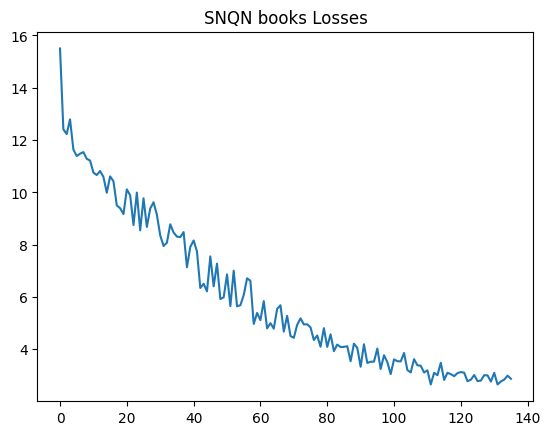

Rewards:
 @5 : 119.60000000000008 @10 : 139.79999999999998 @15 : 146.59999999999988 @20 : 152.39999999999986

Click HR:
 @5 : 0.008446321404756613 @10 : 0.012002667259390976 @15 : 0.012891753723049567 @20 : 0.013780840186708157

Click NDCG:
 @5 : 0.006093911446957584 @10 : 0.007233206042277987 @15 : 0.007467733520581672 @20 : 0.007682119487278985

Purchase HR:
 @5 : 0.03719694453669877 @10 : 0.04284290933244769 @15 : 0.04483560278977084 @20 : 0.046496180670873466

Purchase NDCG:
 @5 : 0.027812147008642096 @10 : 0.029631598146058678 @15 : 0.030164788580067436 @20 : 0.030559271861258633


In [48]:
arg_dict_books = {'r_click' : 0.2,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.005,
            'epoch' : 30,
            'batch_size' : 256,
            'neg' : 10,
            'discount' : 0.5
            }
results_books = []
losses_books = []
QN_1_books, QN_2_books = train(books_data_stats, books_replay_buf, books_val_df, arg_dict=arg_dict_books, results=results_books, losses=losses_books, configuration='SNQN')
plt.plot(losses_books)
plt.title('SNQN books Losses')
plt.show()
_ = last_results(results_books, print_out=True)


### SA2C

/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/RL_RECSYS.py:95: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  self.seq = tf.compat.v1.layers.dropout(self.seq,
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:142: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.compat.v1.layers.dense(queries, num_units, activation=None) # (N, T_q, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:143: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K = tf.compat.v1.layers.dense(keys, num_units, activation=None) # (N, T_k, C)
/Users/kostaseckar/Desktop/HSE/RL_based_RecSys/MY/SASRecModules.py:144: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.la

#############################################################
total clicks: 4499, total purchase:3011
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 5: 0.200000
clicks hr ndcg @ 5 : 0.000222, 0.000111
purchase hr and ndcg @5 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 10: 0.400000
clicks hr ndcg @ 10 : 0.000445, 0.000175
purchase hr and ndcg @10 : 0.000000, 0.000000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 15: 1.400000
clicks hr ndcg @ 15 : 0.000445, 0.000175
purchase hr and ndcg @15 : 0.000332, 0.000093
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cumulative reward @ 20: 2.600000
clicks hr ndcg @ 20 : 0.000667, 0.000228
purchase hr and ndcg @20 : 0.000664, 0.000168
off-line corrected evaluation (click_ng,purchase_ng) @10: 0.000088, 0.000000
#############################################################
the loss in 50th batch is: 15.3240

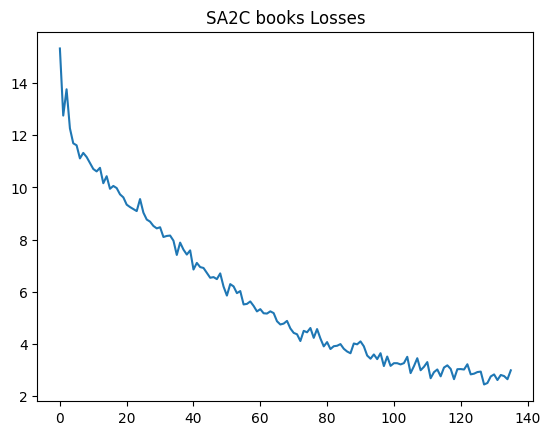

Rewards:
 @5 : 122.00000000000009 @10 : 136.2 @15 : 145.99999999999983 @20 : 149.99999999999983

Click HR:
 @5 : 0.008890864636585907 @10 : 0.011335852411647033 @15 : 0.013336296954878863 @20 : 0.014447655034452101

Click NDCG:
 @5 : 0.005993956279867961 @10 : 0.0067912984797158195 @15 : 0.007305504147404452 @20 : 0.007571473533061193

Purchase HR:
 @5 : 0.03786117568913982 @10 : 0.041846562603786115 @15 : 0.04450348721355032 @20 : 0.04549983394221189

Purchase NDCG:
 @5 : 0.027689213350615274 @10 : 0.028944217023768985 @15 : 0.02965179470699842 @20 : 0.02988523596526203


In [49]:
arg_dict_books = {'r_click' : 0.2,
            'r_buy' : 1,
            'r_negative' : 1,
            'hidden_factor' : 64,
            'lr' : 0.005,
            'lr2' : 0.001,
            'epoch' : 30,
            'batch_size' : 256,
            'neg' : 10,
            'discount' : 0.5,
            'smooth' : 0.0,
            'clip' : 0.0
            }
results_books = []
losses_books = []
QN_1_books, QN_2_books = train(books_data_stats, books_replay_buf, books_val_df, arg_dict=arg_dict_books, results=results_books, losses=losses_books, configuration='SA2C')
plt.plot(losses_books)
plt.title('SA2C books Losses')
plt.show()
_ = last_results(results_books, print_out=True)
